In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.signal import find_peaks, butter, lfilter
from scipy.fft import fft
from collections import deque
import time
import csv

In [52]:
import csv

# Replace 'your_file.csv' with the actual file path
with open('2024-01-05_11-29-10.csv', 'r') as file:
    # Create a CSV reader
    csv_reader = csv.reader(file)
    raw =[]
    # Iterate over rows and print each row
    for row in csv_reader:
        row = np.array(row).astype(float)
        raw.append(row)
        print(np.array(row).astype(float))


[2.00000000e+06 1.00000000e+00 1.00000000e+00 3.10000000e+01
 3.30000000e+01 5.80000000e+10 6.35000000e+10 2.56000000e+02
 1.00000000e+00 1.50000007e-04 5.00000007e-02]
[0.43394384 0.37216118 0.34481075 0.32820514 0.30818072 0.3023199
 0.3003663  0.2989011  0.2989011  0.2989011  0.3008547  0.3028083
 0.30476192 0.30940172 0.31355312 0.30671552 0.30427352 0.31062272
 0.3028083  0.2979243  0.30476192 0.2969475  0.2862027  0.2905983
 0.2920635  0.2884005  0.2891331  0.2876679  0.2852259  0.2852259
 0.2891331  0.2959707  0.3008547  0.3018315  0.30622712 0.31941393
 0.32332113 0.32380953 0.33455434 0.33382174 0.32673994 0.32185593
 0.31599513 0.30769232 0.2962149  0.2935287  0.2925519  0.2842491
 0.2866911  0.2949939  0.3028083  0.31599513 0.32844934 0.33797315
 0.34676436 0.35164836 0.35262516 0.34774116 0.33650795 0.32771674
 0.32136753 0.30866912 0.3008547  0.2979243  0.2964591  0.3018315
 0.31404153 0.32380953 0.33553115 0.34725276 0.35653237 0.36483517
 0.36678877 0.36727718 0.36678877

In [53]:
# raw_data[0].shape

In [54]:
# configuration
sample_rate_Hz, rx_mask, tx_mask, tx_power_level, if_gain_dB, start_frequency_Hz, end_frequency_Hz, num_samples_per_chirp, num_chirps_per_frame, chirp_repetition_time_s, frame_repetition_time_s = raw[0]

In [55]:
raw_data = np.array(raw[1:])
raw_data.shape

# raw[1]

(50, 256)

In [56]:
from scipy import signal
numchirps = 1
chirpsamples = num_samples_per_chirp
col1 = raw_data[0,:]
numchirps = 1
chirpsamples = col1.shape[0]
# chirpsamples
# avgs = np.average(col1,1).reshape(numchirps,1)
range_window = signal.blackmanharris(chirpsamples)
# plt.plot(range_window)


C:\Users\Asus\AppData\Local\Temp\ipykernel_14836\1209396077.py:9: DeprecationWarning: Importing blackmanharris from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackmanharris' or the convenience function 'scipy.signal.get_window' instead.
  range_window = signal.blackmanharris(chirpsamples)


In [69]:
col1 = raw_data[10, :]
data = col1.reshape(1, chirpsamples)

In [70]:
[numchirps, chirpsamples] = np.shape(data)
# numchirps, chirpsamples
range_window = signal.blackmanharris(chirpsamples).reshape(1, chirpsamples)
# range_window.shape

C:\Users\Asus\AppData\Local\Temp\ipykernel_14836\2661991009.py:3: DeprecationWarning: Importing blackmanharris from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackmanharris' or the convenience function 'scipy.signal.get_window' instead.
  range_window = signal.blackmanharris(chirpsamples).reshape(1, chirpsamples)


In [71]:
mat = data 
avgs = np.average(mat, 1).reshape(numchirps, 1)
#de-bias values
mat = mat - avgs
# -------------------------------------------------
# Step 2 - Windowing the Data
# -------------------------------------------------
mat = np.multiply(mat, range_window)

# -------------------------------------------------
# Step 3 - add zero padding here
# -------------------------------------------------
zp1 = np.pad(mat, ((0, 0), (0, chirpsamples)), 'constant')

# -------------------------------------------------
# Step 4 - Compute FFT for distance information
# -------------------------------------------------
range_fft = np.fft.fft(zp1)/chirpsamples

#ignore the redundant info in negative spectrum
#compensate energy by doubling magnitude
range_fft = 2*range_fft[:, range(int(chirpsamples))]
range_fft.shape

(1, 256)

In [72]:
raw[0]

array([2.00000000e+06, 1.00000000e+00, 1.00000000e+00, 3.10000000e+01,
       3.30000000e+01, 5.80000000e+10, 6.35000000e+10, 2.56000000e+02,
       1.00000000e+00, 1.50000007e-04, 5.00000007e-02])

In [73]:
fft_spec_abs = abs(range_fft[0])
# plt.plot(fft_spec_abs)
# Step 3 - coherent integration of all chirps
data = np.divide(fft_spec_abs, numchirps)
skip = 8
max = np.argmax(data[skip:])
start_frequency_Hz = 58000000000
end_frequency_Hz = 63500000000
bandwidth_hz = abs(end_frequency_Hz-start_frequency_Hz)
fft_size = chirpsamples * 2
range_bin_length = (3e8) / (2 * bandwidth_hz * fft_size / chirpsamples)
dist = range_bin_length * (max + skip)

In [74]:
bandwidth_hz

5500000000

In [75]:
bandwidth_hz

5500000000

In [76]:
def calculate_Rangemax(Fs, c, Tc,B):
    Rangemax = Fs * c * Tc / (2*B)
    return Rangemax

# Example usage:
Fs = sample_rate_Hz  # Replace with the actual value for the sampling frequency
c = 3e8   # Replace with the actual value for the constant
Tc = 0.0001500000071246177  # Replace with the actual value for Tc2B
B = bandwidth_hz
range_max = calculate_Rangemax(Fs, c, Tc,B)
print("Rangemax:", range_max,"m")


Rangemax: 8.181818570433693 m


In [77]:
range_m = np.linspace(0, 3.5, chirpsamples)

In [78]:
x = abs(range_fft[0][:100])
indx = np.argmax(x[8:])
peak = indx+8

Range :  0.3431372549019608


Text(0, 0.5, 'Magnitude')

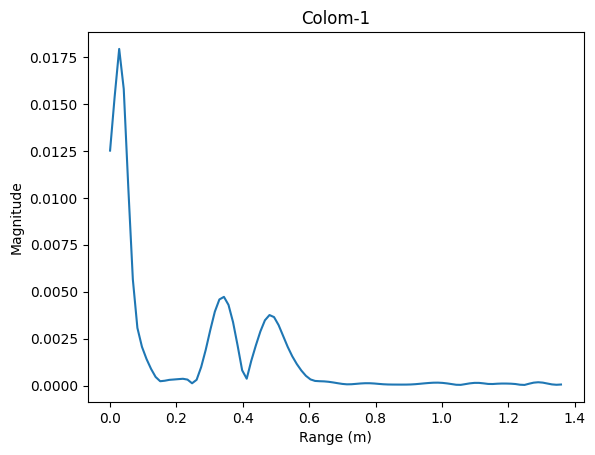

In [79]:
plt.plot(range_m[:100], abs(range_fft[0][:100]))
# plt.plot(abs(range_fft[0]))
print("Range : ",range_m[peak])
plt.title("Colom-1")
plt.xlabel("Range (m)")
plt.ylabel("Magnitude")